In [1]:
import sys
import pandas as pd
import re
sys.path.append(r'./script/')
from ECMpy_function import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# input and output files

In [2]:
json_output_file = './model/ecMTM.json'
json_model_file=json_output_file
reaction_kcat_MW_outfile = './get_reaction_kcat/kcat/reaction_change_by_C13_TurNup24_1.csv'# enzyme data for ecMTM
reaction_kcat_MW = pd.read_csv(reaction_kcat_MW_outfile,index_col=0)
reaction_kcat_MW = round(reaction_kcat_MW,3)


In [3]:
enz_model=get_enzyme_constraint_model(json_model_file)
enz_model.reactions.get_by_id("R1975_num1").bounds=(0,0)
enz_model.reactions.get_by_id("R1975_num2").bounds=(0,0)
enz_model.reactions.get_by_id("R1975_num3").bounds=(0,0)
enz_model.reactions.get_by_id("R1975_num4").bounds=(0,0)
enz_model.reactions.get_by_id("R1975_num5").bounds=(0,0)
pfba_solution = cobra.flux_analysis.pfba(enz_model)
enz_solution=get_min_enzyme_cost(enz_model,reaction_kcat_MW)
min_enzyme_cost=enz_solution.objective_value
enzyme_efficiency= pfba_solution.fluxes['Biomass']/enz_solution.objective_value
print(min_enzyme_cost,enzyme_efficiency)

0.128
0.12799999649527227 2.8589755528692744


# Biomass Yield on Different Carbon Sources

In [4]:


substrate_list=[{'R2399_reverse':'D-Glucose'},{'R2417':'Cellobiose'},{'R2401':'D-Galactose'},{'R2408':'D-Xylose'},{'R2406':'L-Arabinose'}] 


yield_list = pd.DataFrame()
for i in substrate_list:


    enz_model=get_enzyme_constraint_model(json_model_file)
    enz_model.reactions.get_by_id("R2393").bounds=(0,0)
    enz_model.reactions.get_by_id("R2394").bounds=(-1000,1000)
    enz_model.reactions.get_by_id('R2399_reverse').bounds=(0,0)
    enz_model.reactions.get_by_id('R2399').bounds=(0,0)
    enz_model.reactions.get_by_id(list(i.keys())[0]).bounds=(-5,5)
    pfba_solution = cobra.flux_analysis.pfba(enz_model)
    enz_solution=get_min_enzyme_cost(enz_model,reaction_kcat_MW)
    min_enzyme_cost=enz_solution.objective_value
    enzyme_efficiency= pfba_solution.fluxes['Biomass']/enz_solution.objective_value
    print("substrate uptake：",pfba_solution.fluxes[i])
    yield_list.loc[list(i.values())[0],'min_enzyme_cost']=min_enzyme_cost
    yield_list.loc[list(i.values())[0],'enzyme_efficiency']=enzyme_efficiency
    yield_list.loc[list(i.values())[0],'ecGEM_flux']=pfba_solution.fluxes['Biomass']



0.128
糖的通量： R2399_reverse    5.0
Name: fluxes, dtype: float64
0.128
糖的通量： R2417   -5.0
Name: fluxes, dtype: float64
0.128
糖的通量： R2401   -4.310054
Name: fluxes, dtype: float64
0.128
糖的通量： R2408   -4.822906
Name: fluxes, dtype: float64
0.128
糖的通量： R2406   -3.819919
Name: fluxes, dtype: float64


# 生物质前体

In [5]:

substrate_list=[{'R2399_reverse':'D-Glucose'},{'R2417':'Cellobiose'},{'R2401':'D-Galactose'},{'R2408':'D-Xylose'},{'R2406':'L-Arabinose'}] 


min_enzyme = pd.DataFrame()
efficiency=pd.DataFrame()
bilist=['g6p_c','f6p_c','g3p_c','3pg_c','pep_c','pyr_c','accoa_m','oaa_m','akg_m','succ_m','e4p_c','R5P_c']
for index in substrate_list:
    for name in bilist:
        enz_model=get_enzyme_constraint_model(json_model_file)
        
        product = enz_model.metabolites.get_by_id(name)
        demand = enz_model.add_boundary(product, type='demand')  # add demand reaction as the objective 
        enz_model.objective = demand
        print('demand:',demand.id)


        enz_model.reactions.get_by_id('R2399_reverse').bounds=(0,0)
        enz_model.reactions.get_by_id('R2399').bounds=(0,0)
        if list(index.keys())[0]=='R2417':
            enz_model.reactions.get_by_id(list(index.keys())[0]).bounds=(-1.25,1.25)
        elif list(index.keys())[0]=='R2408' or list(index.keys())[0]=='R2406':
            enz_model.reactions.get_by_id(list(index.keys())[0]).bounds=(-3,3)
        else :
            enz_model.reactions.get_by_id(list(index.keys())[0]).bounds=(-2.5,2.5)
        #计算酶量以及效率
        print(index,name)
        pfba_solution = cobra.flux_analysis.pfba(enz_model)
        enz_solution=get_min_enzyme_cost(enz_model,reaction_kcat_MW)
        min_enzyme_cost=enz_solution.objective_value
        enzyme_efficiency= pfba_solution.fluxes[demand.id]/enz_solution.objective_value
        min_enzyme.loc[list(index.values())[0],name.upper()]=min_enzyme_cost
        efficiency.loc[list(index.values())[0],name.upper()]=enzyme_efficiency
        fluxes_outfile='./analysis/'+list(index.values())[0]+name+'.csv'
        get_fluxes_detail_in_model(enz_model,enz_solution,fluxes_outfile,json_model_file)
    

0.128
demand: DM_g6p_c
{'R2399_reverse': 'D-Glucose'} g6p_c
Enzyme cost total is:0.026766671801793623
0.128
demand: DM_f6p_c
{'R2399_reverse': 'D-Glucose'} f6p_c
Enzyme cost total is:0.025564966555273714
0.128
demand: DM_g3p_c
{'R2399_reverse': 'D-Glucose'} g3p_c
Enzyme cost total is:0.03779497941496158
0.128
demand: DM_3pg_c
{'R2399_reverse': 'D-Glucose'} 3pg_c
Enzyme cost total is:0.019647380316389653
0.128
demand: DM_pep_c
{'R2399_reverse': 'D-Glucose'} pep_c
Enzyme cost total is:0.02252861009049719
0.128
demand: DM_pyr_c
{'R2399_reverse': 'D-Glucose'} pyr_c
Enzyme cost total is:0.007915963331416701
0.128
demand: DM_accoa_m
{'R2399_reverse': 'D-Glucose'} accoa_m
Enzyme cost total is:0.12799999999999956
0.128
demand: DM_oaa_m
{'R2399_reverse': 'D-Glucose'} oaa_m
Enzyme cost total is:0.02332557360960845
0.128
demand: DM_akg_m
{'R2399_reverse': 'D-Glucose'} akg_m
Enzyme cost total is:0.10586568181084526
0.128
demand: DM_succ_m
{'R2399_reverse': 'D-Glucose'} succ_m
Enzyme cost total is:

In [6]:
min_enzyme

,G6P_C,F6P_C,G3P_C,3PG_C,PEP_C,PYR_C,ACCOA_M,OAA_M,AKG_M,SUCC_M,E4P_C,R5P_C
D-Glucose,0.026767,0.025565,0.037795,0.019647,0.022529,0.007916,0.128,0.023326,0.105866,0.027127,0.041487,0.035767
Cellobiose,0.022280,0.021770,0.034187,0.016570,0.019451,0.008276,0.128,0.023516,0.100826,0.027002,0.037935,0.032128
D-Galactose,0.036686,0.036819,0.049049,0.030901,0.033783,0.019170,0.128,0.033647,0.117120,0.038336,0.052741,0.047021
D-Xylose,0.045565,0.044193,0.053902,0.035754,0.038635,0.024023,0.128,0.036846,0.121972,0.042531,0.051955,0.039953
L-Arabinose,0.065336,0.063984,0.069972,0.057686,0.060568,0.039810,0.128,0.049776,0.128000,0.057276,0.066359,0.058851


In [7]:
efficiency

,G6P_C,F6P_C,G3P_C,3PG_C,PEP_C,PYR_C,ACCOA_M,OAA_M,AKG_M,SUCC_M,E4P_C,R5P_C
D-Glucose,87.729492,91.853300,120.801940,254.486886,221.940045,631.635143,3.753914,160.767756,28.337798,138.239520,83.703453,78.334793
Cellobiose,107.004270,109.508783,135.588403,301.756049,257.057446,604.187493,3.861204,159.467036,29.754287,138.879221,92.936583,88.537538
D-Galactose,64.008880,63.777689,93.084706,161.805264,148.005308,260.825187,3.554754,111.450576,25.614833,97.818311,65.842703,59.586319
D-Xylose,51.323366,52.916493,84.704564,139.844729,129.415768,208.137995,3.455045,101.775584,24.595762,88.172012,66.838525,70.127922
L-Arabinose,35.298319,36.044663,64.758032,86.675431,82.552247,125.595708,3.113460,75.337103,22.753999,65.472071,51.866610,47.026051


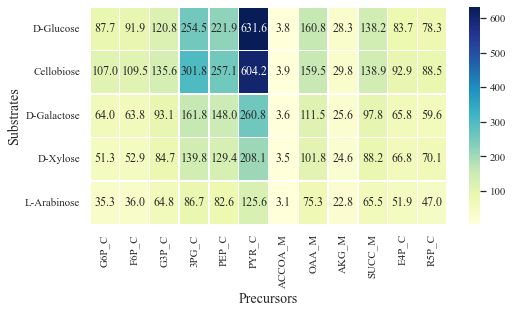

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=efficiency
df = df.astype(float)

sns.set(style="whitegrid", font='Times New Roman')


plt.figure(figsize=(8, 4))

sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=.5)


# plt.title('Substrate Utilization', fontdict={'fontsize': 16, 'family': 'Times New Roman'})
plt.xlabel('Precursors', fontdict={'fontsize': 14, 'family': 'Times New Roman'})
plt.ylabel('Substrates', fontdict={'fontsize': 14, 'family': 'Times New Roman'})

# 保存图像
plt.savefig('analysis/层级利用结果20231月17.png', bbox_inches='tight', dpi=300)
plt.show()
